>Accuracy real: 1%, fake: 52%


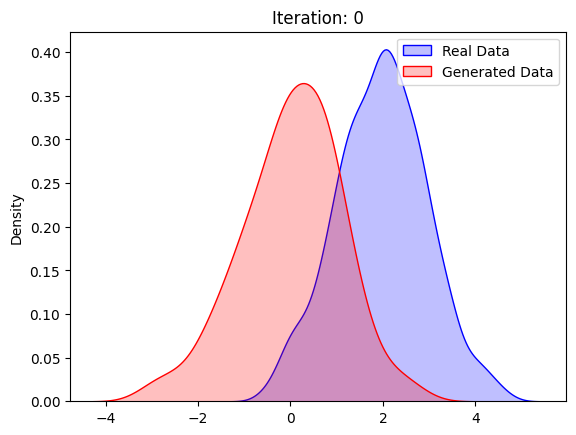

>Accuracy real: 87%, fake: 69%


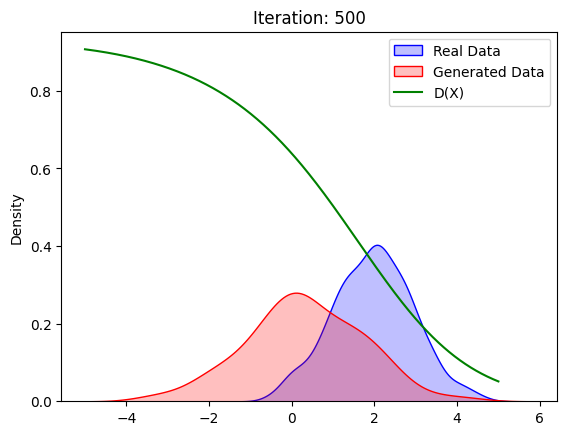

>Accuracy real: 35%, fake: 74%


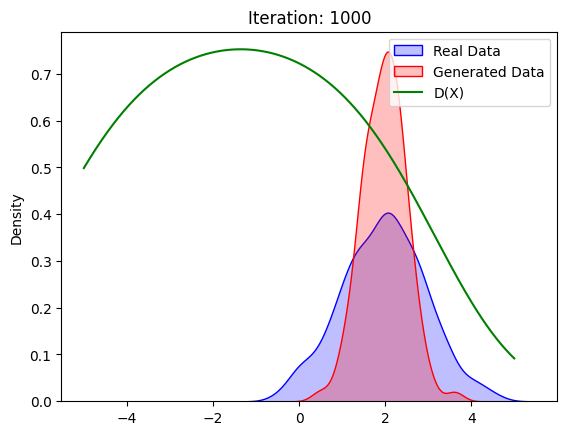

>Accuracy real: 52%, fake: 43%


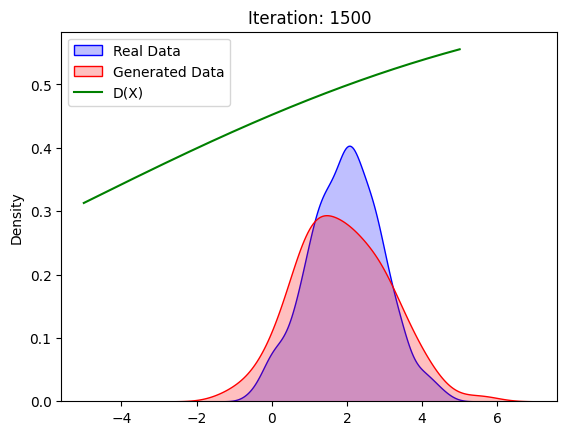

>Accuracy real: 58%, fake: 57%


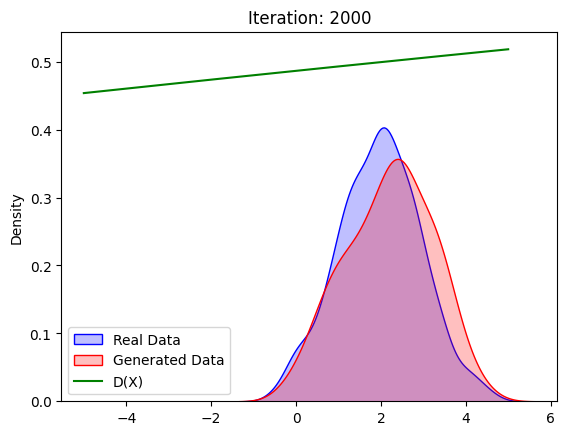

>Accuracy real: 16%, fake: 91%


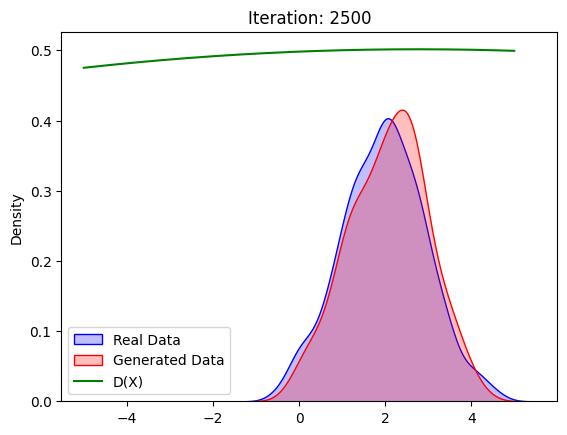

>Accuracy real: 64%, fake: 40%


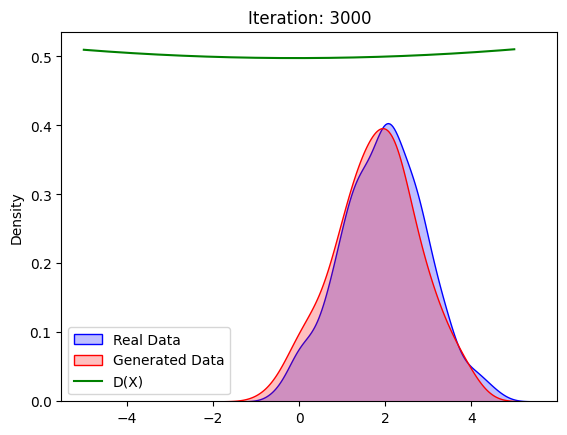

In [3]:
import seaborn as sns
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Lambda
from keras import backend as K
from keras.layers import Input, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(1, input_shape=(latent_dim,), activation='linear', use_bias=True))
    return model

def define_discriminator():
  model = Sequential()
  model.add(Lambda(lambda x: K.concatenate([x, K.square(x)], axis=-1)))
  model.add(Dense(1, input_shape=(2,), activation='sigmoid', use_bias=True))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model




def load_real_samples(data_mean,data_std, n_samples=1000):

  X = np.random.normal(data_mean, data_std, size=(n_samples, 1))
  return X

# select real sample
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = ones((n_samples, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input =  np.random.normal(0,1, size=(latent_dim * n_samples))
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input,verbose=0)
  # create 'fake' class labels (0)
  y = zeros((n_samples, 1))
  return X, y

# Define a function to plot the distributions
def plot_distributions(iteration,real_data, generated_data,D_X):
    if iteration ==0:
      sns.kdeplot(real_data.flatten(), fill=True, color='blue', label='Real Data')
      sns.kdeplot(generated_data.flatten(), fill=True, color='red', label='Generated Data')

      plt.title(f'Iteration: {iteration}')
      plt.legend()
      plt.show()

    else:
      D_X=1-D_X
      sns.kdeplot(real_data.flatten(), fill=True, color='blue', label='Real Data')
      sns.kdeplot(generated_data.flatten(), fill=True, color='red', label='Generated Data')
      plt.plot(np.linspace(-5,5,1000),D_X.flatten(), color='green', label='D(X)')
      plt.title(f'Iteration: {iteration}')
      plt.legend()
      plt.show()
    

 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  D_X=d_model.predict(np.linspace(-5,5,1000),verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

  plot_distributions(epoch,dataset, x_fake,D_X)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  filename2 = 'discriminator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)
  d_model.save(filename2)



# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3005, n_batch=64):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
  # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      # print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      # evaluate the model performance, sometimes
    if (i+1) % 500 == 0:
      summarize_performance(i+1, g_model, d_model, dataset, latent_dim)
    elif (i)== 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
         


data_mean = 2
data_std = 1
# size of the latent space
latent_dim = 10
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(2,1)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)
